### LoopFlopy Example 2 - 3D Model

In [33]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import subprocess
import sys
import os
import pickle
import flopy
import geopandas as gpd
from shapely.geometry import LineString,Point,Polygon,MultiPolygon,MultiPoint,shape

%load_ext autoreload
%autoreload 2

import loopflopy
import loopflopy.utils as utils

print(loopflopy.__file__)
modules = utils.list_modules(loopflopy)
for module in modules: 
    print(module)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
C:\Users\00105295\Projects\loopflopy\src\loopflopy\__init__.py
dem
disv2disu
flowmodel
flowmodel_routines
geomodel
geomodel2
geomodel_routines
mesh
mesh_routines
observations
project
properties
properties2
spatial
spatial_routines
structuralmodel
surfacerefinement
utils


### 1. Setup Project

In [34]:
# Project setup
name = 'example'
workspace = '../modelfiles/'
results = '../results/'
figures = '../figures/'
triexe = '../exe/triangle.exe'
mfexe_name = '../exe/mf6.exe'

from loopflopy.project import Project
project = Project(name, workspace, results, figures, triexe, mfexe_name)
project.crs = 28350  # UTM zone 50S, EPSG:28350

### 2. Spatial

In [35]:
from loopflopy.spatial import Spatial
spatial = Spatial(epsg = 28350)

import process_spatial
process_spatial.model_boundary(spatial, boundary_buff = 1000, simplify_tolerance = 800, node_spacing = 2000)
spatial.x0, spatial.x1, spatial.y0, spatial.y1

(349088.0373017123, 392718.4692868978, 6507368.199997337, 6546515.9098643325)

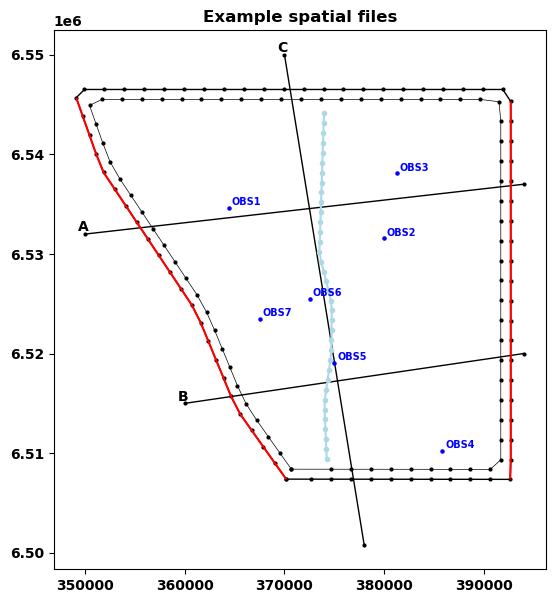

In [36]:
process_spatial.obs_bores(spatial)
process_spatial.geo_bores(spatial)
process_spatial.pump_bores(spatial)
process_spatial.head_boundary(spatial)
process_spatial.faults(spatial)

spatial.xsection_names = ['A', 'B', 'C']
spatial.xsections = [
                     [(350000, 6532000),(394000, 6537000)], 
                     [(360000, 6515000),(394000, 6520000)],
                     [(370000, 6550000),(378000, 6500800)]
                     ]

process_spatial.plot_spatial(spatial, 
                             obsbores = True, 
                             pilotpoints = True,
                             pumpbores = False, 
                             geobores = False, 
                             xsections = True, 
                             fault = True)

In [37]:
# Create a map
m = spatial.obsbore_gdf.explore(location=[-31.4, 115.8], zoom_start=10, popup = 'id')
spatial.model_boundary_gdf.explore(m=m, fill = False)
spatial.faults_gdf.explore(m=m, color = 'red')
spatial.pumpbore_gdf.explore(m=m, color = 'red', popup = 'id')

### 3. Structural Model

In [38]:
# A bounding box for structural model
x0, x1 = 348000, 400000
y0, y1 = 6500000, 6550000
z0, z1 = -1000, 300
bbox = [(x0, y0, z0), (x1, y1, z1)]

from loopflopy.spatial_routines import make_bbox_shp
crop_polygon = make_bbox_shp(x0, x1, y0, y1, crs=project.crs, fname = '../data/shp/structuralmodel.shp')

geodata_fname = '../data/example_data.xlsx'
data_sheetname = 'geo_bores'
strat_sheetname = 'strat'

from loopflopy.structuralmodel import StructuralModel
structuralmodel = StructuralModel(bbox, geodata_fname, data_sheetname, strat_sheetname)

import process_structural
process_structural.prepare_strat_column(structuralmodel)
process_structural.prepare_geodata(structuralmodel, spatial, Fault = False)
process_structural.create_structuralmodel(structuralmodel, Fault = True)

structuralmodel.faults = ['Fault']
#structuralmodel.data

['Ground', 'TQ', 'Kcok', 'Kwlp', 'Kwlw', 'Kwlm']
['Ground', 'TQ', 'Kcok', 'Leed']
1.6.14
Fault included!


c:\Users\00105295\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


ERROR: 2026-02-17 08:08:36,379: _geological_feature_builder.py:239 -- Not enough constraints for scalar field add more
ERROR: 2026-02-17 08:08:36,657: _geological_feature_builder.py:239 -- Not enough constraints for scalar field add more
ERROR: 2026-02-17 08:08:37,028: _geological_feature_builder.py:239 -- Not enough constraints for scalar field add more


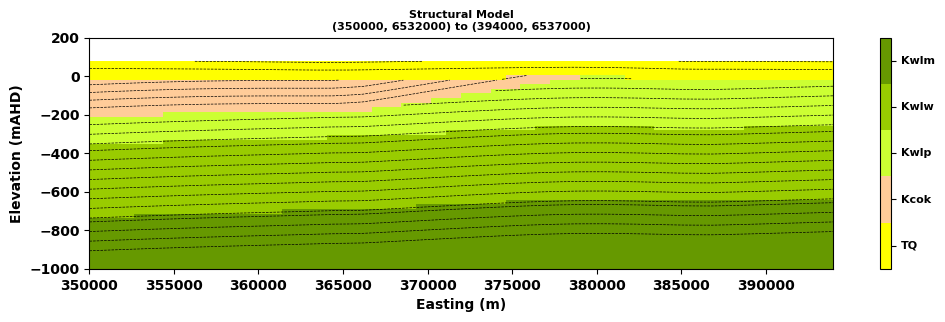

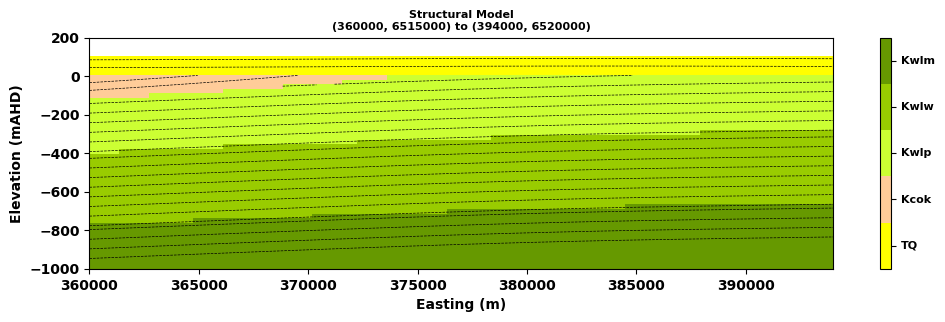

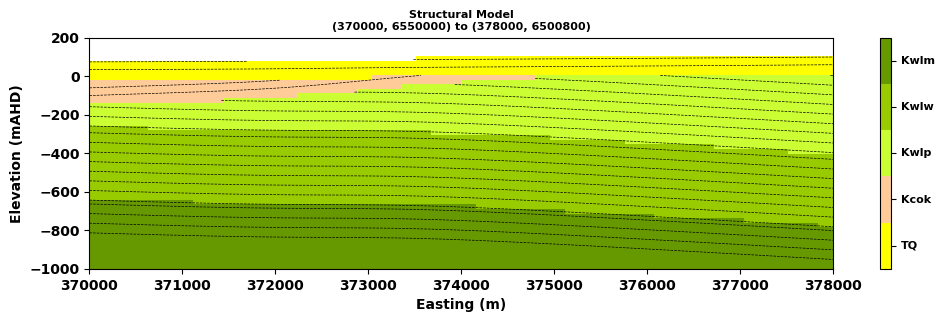

In [39]:
z0 = -1000 # just for plotting. Make sure within bbox of structural model
z1 = 200   # just for plotting. Make sure within bbox of structural model
nh, nv = 50, 50 # plotting resolution
dz = [40, 40, 50, 50, 50]

for i in range(len(spatial.xsections)):
    x0, x1 = spatial.xsections[i][0][0], spatial.xsections[i][1][0] # A
    y0, y1 = spatial.xsections[i][0][1], spatial.xsections[i][1][1] # A

    structuralmodel.plot_transect(x0, x1, y0, y1, z0, z1, nh, nv, dz)

### 4. Meshing

In [40]:
# Create mesh object
from loopflopy.mesh import Mesh
special_cells = {
                 'chd': ['east', 'west'], 
                 'wel': ['pumpbores'], 
                 'obs': ['obsbores'], 
                 }
mesh = Mesh(plangrid = 'vor', special_cells = special_cells) # special cells to identify as arguements 

In [41]:
# Define mesh parameters and create mesh
mesh.modelmaxtri = 600000
mesh.boundmaxtri = 600000
mesh.angle = 32   # minimum triangle angles
mesh.radius1 = 400 # 50, 200 radius of inner circle around pumping bores
mesh.radius2 = 800 # 200, 600 radius of outer circle around pumping bores
mesh.boremaxtri = 99999999
mesh.ncol, mesh.nrow = 50, 50

mesh.create_bore_refinement(spatial)

spatial.fault_nodes = loopflopy.mesh_routines.prepare_fault_nodes_voronoi(spatial.faults_gdf, 
                                                    spatial.model_boundary_poly, 
                                                    spatial.inner_boundary_poly, 
                                                    fault_buffer = 800)

Creating bore refinement nodes for pumping bores


In [42]:
node_list = ['bore_refinement_nodes', 'fault_nodes'] 
polygon_list = ['model_boundary_poly', 'inner_boundary_poly']

mesh.prepare_nodes_and_polygons(spatial, node_list, polygon_list)
mesh.create_mesh(project, spatial)

print('number of cells in plan = ', mesh.ncpl)

bore_refinement_nodes
fault_nodes
Creating Voronoi grid
number of cells in plan =  2073


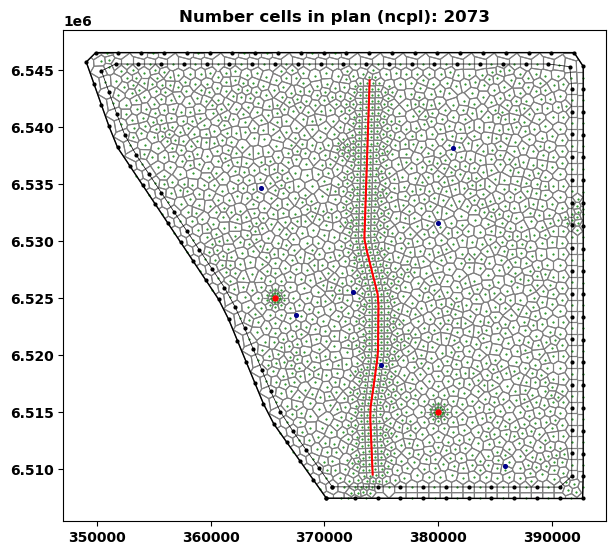

In [43]:
xlim = [spatial.x0 - 2000, spatial.x1 + 2000]
ylim = [spatial.y0 - 2000, spatial.y1 + 2000]

features = ['wel', 'obs', 'fault']#,'river']
mesh.plot_cell2d(spatial, features, xlim = xlim, ylim = ylim)

### 5. Find Cell IDs of spatial features

Group =  chd ['east', 'west']
flag = 1
chd_east_cells [  45   46   47   48   49   50   51   52   53   54   55   56   57   58
   59   60   61   62   63   64  796  799  800  802  804  805  808  810
  811  813  816  817  819  822  824  825  827  830  832 1046]
chd_west_cells [   0    1    2    3    4    5    6    7    8    9   10   11   12   13
   14   15   16   17   18   19   20   21   22  858  861 1013 1463 1470
 1884 1887 1920 1948 1963 1965]
Group =  wel ['pumpbores']
flag = 3
Group =  obs ['obsbores']
flag = 4
[0 1 2 3 4]
[0 1 2 3 4]


c:\Users\00105295\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\flopy\utils\gridintersect.py:936: DeprecationWarning: In the future this function will return a dataframe by default. Set dataframe=True to adopt future behavior and silence this warning. Set dataframe=False to silence this warning and maintain old behavior
  warnings.warn(
c:\Users\00105295\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\flopy\utils\gridintersect.py:936: DeprecationWarning: In the future this function will return a dataframe by default. Set dataframe=True to adopt future behavior and silence this warning. Set dataframe=False to silence this warning and maintain old behavior
  warnings.warn(
c:\Users\00105295\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\flopy\utils\gridintersect.py:290: DeprecationWarning: In the future this function will return a GeoDataFrame by default. Set geo_dataframe=True to adopt future behavior and silence this warning. Set geo_dataframe=False to sil

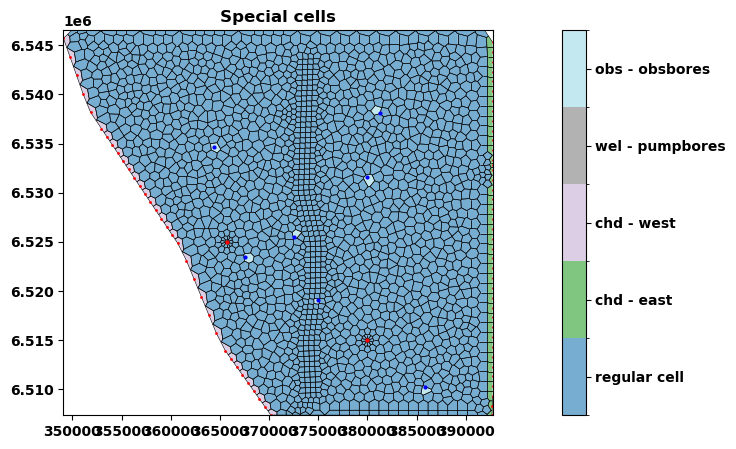

In [44]:
# Locate special cells and plot
mesh.locate_special_cells(spatial)

xlim = [355000, 370000]
ylim = [6525000, 6535000]

mesh.plot_feature_cells(spatial, xlim = None, ylim = None, plot_grid= True)

### 5. Geomodel

In [46]:
# Set up Geomodel (lithological block model of cells)
scenario = 'example'
vertgrid = 'con'    # {voxel: nlay, z0, z1} {con:   nls, res} {con2:  nls, res, max_thick}
z0, z1 = -1000, 200 
surface = z1 * np.ones((mesh.ncpl), dtype=float) # empty array to fill in ground surface

from loopflopy.geomodel import Geomodel
geomodel = Geomodel(scenario, mesh, structuralmodel, vertgrid, z0, z1)

geomodel.evaluate_structuralmodel(res = 3) # resolution of surfaces (con and con2), surfaces calculated at a 3m resolution
geomodel.create_model_layers(surface, 
                             max_thick = [150, 150, 150, 150, 150], # This puts in extra layers to ensure layers aren't too thick
                             nls = 2, # number of sublayer (con and con2)
                             )

Creating Geomodel for  example  ...

0. Creating xyz array... 
   Time taken Block 0 (creating xyz array) =  1.102714

1. Evaluating structural model... 
   len(xyz) =  829200
   Time taken Block 1 (Evaluate model) =  31.031698

2. Creating geo model layers...
   dz calculated from z0, z1 and nlay =  3.0
   nlay =  400
   ncpl =  2073
   nlg number of geo layers =  5
   botm_geo_shape (5, 2073)
   idomain_geo unique values and counts:  (array([0., 1.]), array([ 900, 9465]))
   Note: Geomodel bottom = flat at z0 (not bottom of geo layer)
   idomain_geo unique values and counts:  (array([0., 1.]), array([ 900, 9465]))
   Time taken Block 2 (Create geological model layers) 0.115634

3. Creating flow model layers...
   number of geological layers in geomodel =  5
   Time taken Block 3 create flow model layers =  0.008001

4. Calculating cellids and gradients...
   Time taken Block 4 gradients=  1.68686


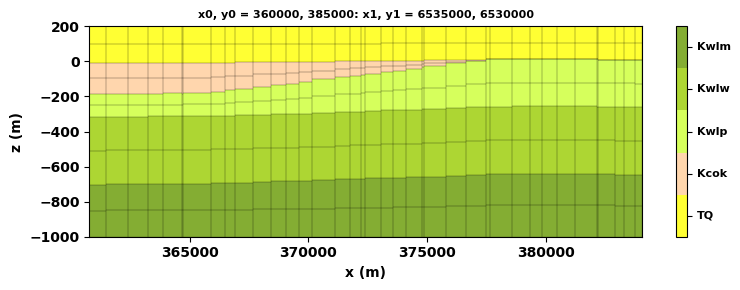

In [47]:
x0 = 360000
y0 = 6535000
x1 = 385000
y1 = 6530000
geomodel.geomodel_transect_lith(x0=x0, x1=x1,
                                y0=y0, y1=y1)
                                #figsize = (8,3),
                                #)# z0 = -200, z1 = 300

In [48]:
# FILL CELL PROPERTIES
props = pd.read_excel(structuralmodel.geodata_fname, sheet_name = 'properties')
props = props.drop(index=[0]).reset_index()#inplace=True) # drop first row as it is ground
geomodel.hk_perlay = props.hk.tolist()
geomodel.vk_perlay = props.vk.tolist()
geomodel.ss_perlay = props.ss.tolist()
geomodel.sy_perlay = props.sy.tolist()
geomodel.iconvert_perlay = props.iconvert.tolist()
geomodel.fill_cell_properties(mesh)
props


5. Filling cell properties...
   ang1 shape  (10, 2073)
   angle1 shape  (18930,)
   Time taken Block 5 Fill cell properties =  0.0


,index,unit,hk,vk,ss,sy,iconvert
0,1,TQ,10.0,1.00,0.0001,0.1,1.0
1,2,Kcok,0.1,0.01,0.0001,0.1,0.0
2,3,Kwlp,1.0,0.10,0.0001,0.1,0.0
3,4,Kwlw,5.0,0.50,0.0001,0.1,0.0
4,5,Kwlm,100.0,1.00,0.0001,0.1,0.0


### 6. Prepare Data for Flowmodel

In [49]:
from process_data import Data
data = Data()

data.process_ic()#geomodel)
data.process_rch(geomodel, mesh)
data.process_chd(spatial, geomodel, mesh)

wel_q = [0, 0]
wel_qlay= [0, 0]
data.process_wel(geomodel, mesh, spatial, wel_q, wel_qlay)


Well screens  [(np.float64(-1000.0), np.float64(14.0)), (np.float64(-1000.0), np.float64(2.0))]


In [50]:
from loopflopy.observations import Observations
import process_observations

df = pd.read_excel('../data/example_data.xlsx', sheet_name='obs_bores')
observations = Observations(df)
observations.gdf = process_observations.make_obs_gdf(df, geomodel, mesh, spatial)
#observations.gdf

All geometries are within the polygon.


In [51]:
observations.make_recarray()
observations.obs_rec

[['OBS1', 'head', 5069],
 ['OBS2', 'head', 7926],
 ['OBS3', 'head', 8014],
 ['OBS4', 'head', 12343],
 ['OBS5', 'head', 6808],
 ['OBS6', 'head', 7038],
 ['OBS7', 'head', 5895]]

### 8. Create and run steady-state flow model

In [52]:
from loopflopy.flowmodel import Flowmodel
scenario = 'steadymodel'
fm = Flowmodel(scenario, project, data, observations, mesh, geomodel)

##### Write and run flowmodel

In [53]:
# Write and run flow model files
sim, gwf = fm.write_flowmodel(chd = True, wel = True, obs = True, rch = True, evt = False)
fm.run_flowmodel(sim)

Writing simulation and gwf for  steadymodel  ...
    xt3d =  True
    staggered =  True
    transient =  False
    mf6 executable expected:  ../exe/mf6.exe
Time taken to write flow model =  11.508417
Running simulation for  steadymodel  ...
Model success =  True
run_time =  5.014652
['DISU', 'NPF', 'IC', 'STO', 'WEL_0', 'CHD_0', 'RCH_0', 'OBS_0', 'OC']
head results shape  (1, 18930)
Type bud  <class 'flopy.utils.binaryfile.CellBudgetFile'>


In [54]:
utils.print_object_details(fm)

Methods:
get_watertable
plot_particles
plot_plan
plot_transect
plot_watertable
prepare_particles
run_flowmodel
run_modpath
write_flowmodel

Variables
chd
chdflow
data
disu_gridprops
evt
geomodel
ghb
gwf
head
lith
logk11
logk33
mesh
newtonoptions
obs
obsdata
observations
project
qx
qy
qz
rch
runtime
scenario
spd
staggered
transient
wel
xt3d
zbud


In [55]:
# IF A PROBLEM NODE FROM MFSIM, CAN LOT LOCATION HERE!
utils.plot_node(1508-1, geomodel, structuralmodel, spatial, sim, scenario, z1 = 500, 
                features = [])#['fault'])

Node one based =  1508 Node zero based =  1507
XYZ problem =  379329.8207922883 6540528.542708416 149.75
cell width approx  912.3939760396024
cell length approx  950.6508558569476
cell thickness 100.5
lay, icpl (0, 1507)


<Figure size 640x480 with 0 Axes>

##### Plot watertable

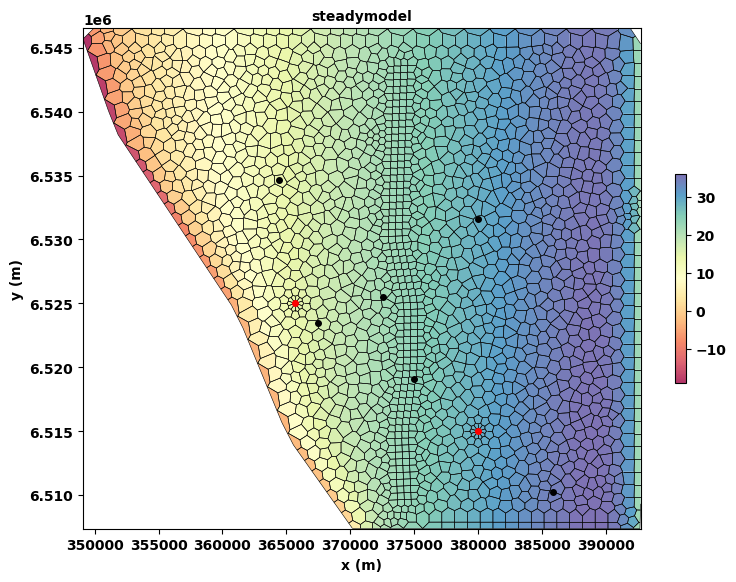

In [56]:
watertable = fm.get_watertable(geomodel, fm.head)
fm.plot_watertable(spatial, geomodel, fm, watertable,plot_grid = True)#, extent, vmin, vmax

##### Plot transects - head

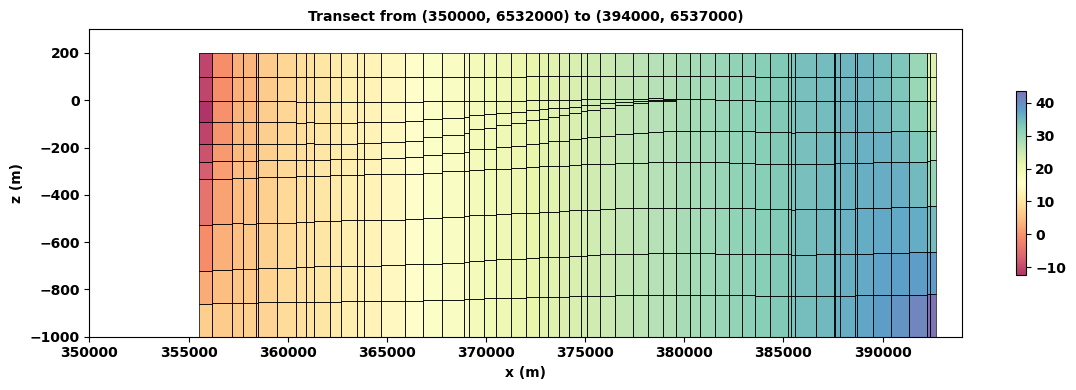

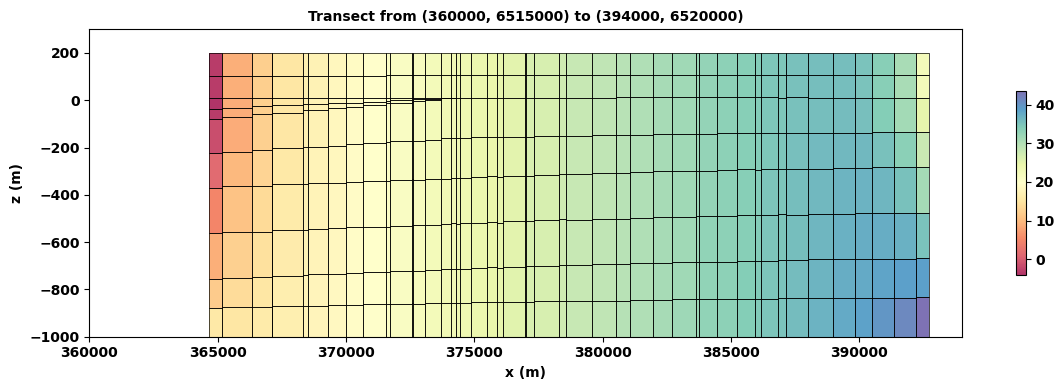

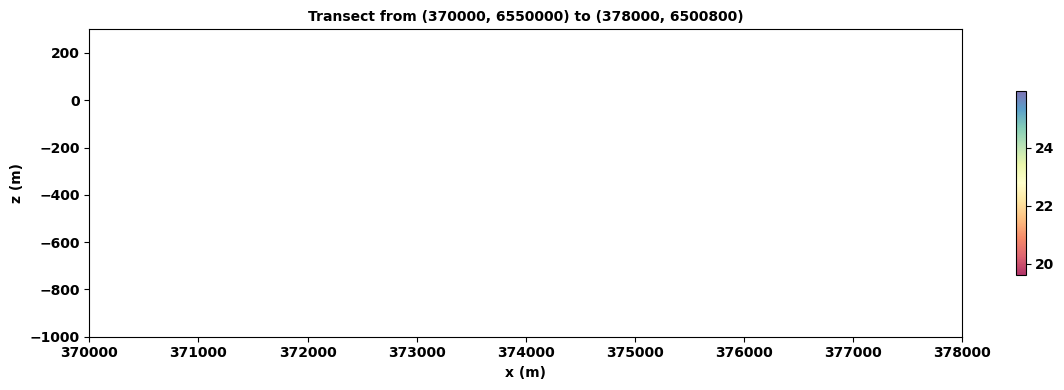

In [57]:
for i in range(len(spatial.xsections)):
    x0, x1 = spatial.xsections[i][0][0], spatial.xsections[i][1][0] # A
    y0, y1 = spatial.xsections[i][0][1], spatial.xsections[i][1][1] # A
    title = f"Transect from ({x0}, {y0}) to ({x1}, {y1})"
    fm.plot_transect(mesh, spatial, geomodel, 'head', title = title, x0 = x0, x1 = x1, y0 = y0, y1 = y1, z1 = 300)

##### Plot transects - lithology

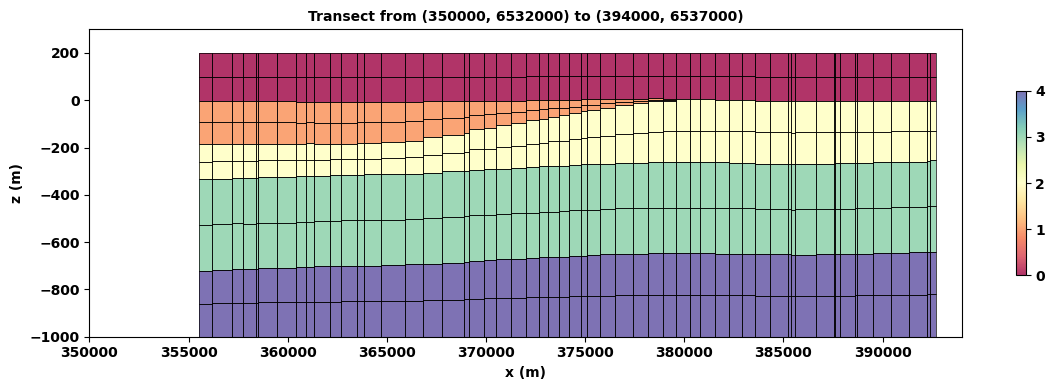

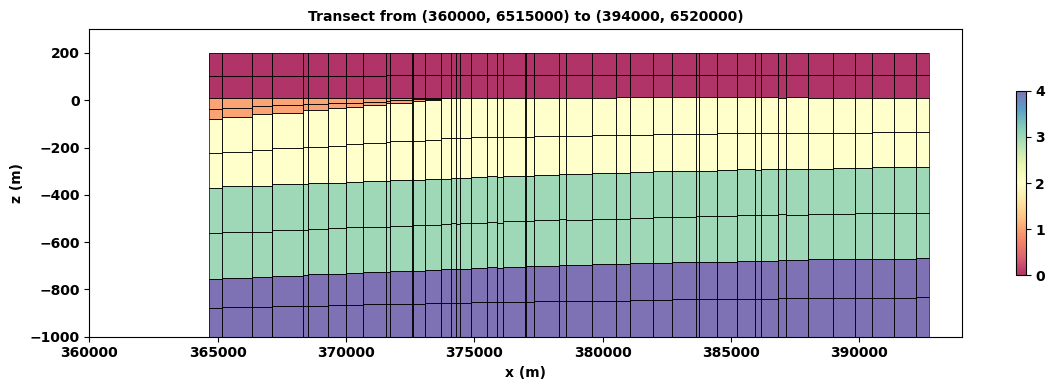

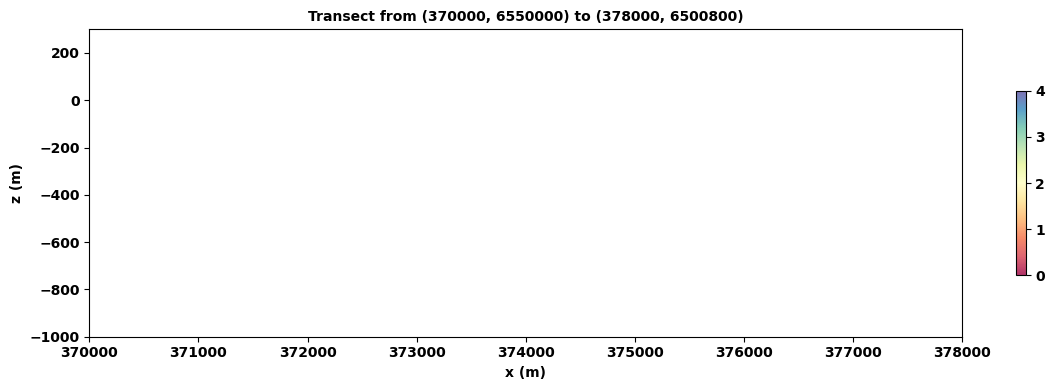

In [58]:
for i in range(len(spatial.xsections)):
    x0, x1 = spatial.xsections[i][0][0], spatial.xsections[i][1][0] # A
    y0, y1 = spatial.xsections[i][0][1], spatial.xsections[i][1][1] # A
    title = f"Transect from ({x0}, {y0}) to ({x1}, {y1})"
    fm.plot_transect(mesh, spatial, geomodel, 'lith', title = title, x0 = x0, x1 = x1, y0 = y0, y1 = y1, z1 = 300)

In [59]:
obj = fm
methods = [func for func in dir(obj) if callable(getattr(obj, func)) and not func.startswith("__")]
print("Methods in the class:  ",methods)
attributes = [attr for attr in dir(obj) if not callable(getattr(obj, attr)) and not attr.startswith("__")]
print("\nAttributes in the class:  ", attributes)

#for attribute, value in flowmodel.data.__dict__.items(): print(attribute)

Methods in the class:   ['get_watertable', 'plot_particles', 'plot_plan', 'plot_transect', 'plot_watertable', 'prepare_particles', 'run_flowmodel', 'run_modpath', 'write_flowmodel']

Attributes in the class:   ['chd', 'chdflow', 'data', 'disu_gridprops', 'evt', 'geomodel', 'ghb', 'gwf', 'head', 'lith', 'logk11', 'logk33', 'mesh', 'newtonoptions', 'obs', 'obsdata', 'observations', 'project', 'qx', 'qy', 'qz', 'rch', 'runtime', 'scenario', 'spd', 'staggered', 'transient', 'wel', 'xt3d', 'zbud']


### 9. Create and run transient flow model

In [60]:
scenario = 'transientmodel'
well_q = [-7000, -7000]
data.process_wel(geomodel, mesh, spatial, well_q, wel_qlay)
data.strt = fm.head
fm2 = Flowmodel(scenario, project, data, observations, mesh, geomodel)

perlen = 2 * 365 # length of period (days)
nts = 12         # number of time steps for this period
fm2.perioddata = [(perlen, nts, 1.1)] # perlen, nts, tsmult

Well screens  [(np.float64(-1000.0), np.float64(14.0)), (np.float64(-1000.0), np.float64(2.0))]


##### Write and run flowmodel

In [61]:
sim, gwf = fm2.write_flowmodel(transient = True, chd = True, wel = True, obs = True, rch = True, evt = False)

Writing simulation and gwf for  transientmodel  ...
    xt3d =  True
    staggered =  True
    transient =  True
    mf6 executable expected:  ../exe/mf6.exe
Time taken to write flow model =  13.736516


In [62]:
fm2.run_flowmodel(sim)# transient = True)

Running simulation for  transientmodel  ...
Model success =  True
run_time =  26.714882
['DISU', 'NPF', 'IC', 'STO', 'WEL_0', 'CHD_0', 'RCH_0', 'OBS_0', 'OC']
head results shape  (1, 18930)
Type bud  <class 'flopy.utils.binaryfile.CellBudgetFile'>


##### Plot watertable

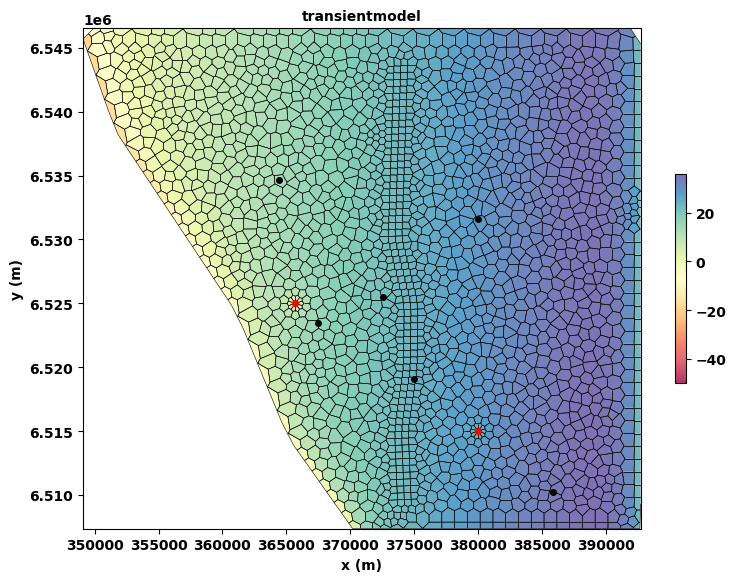

In [63]:
watertable = fm2.get_watertable(geomodel, fm2.head)
fm2.plot_watertable(spatial, geomodel, fm2, watertable, plot_grid = True)#, extent, vmin, vmax

##### Plot transects

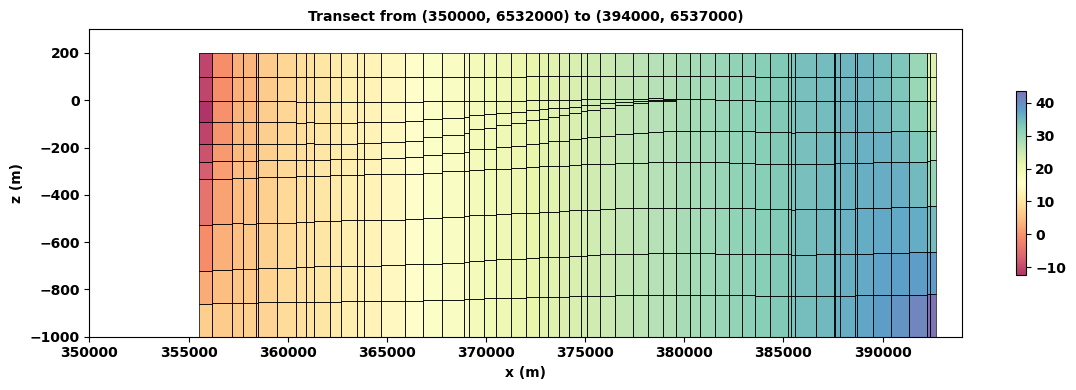

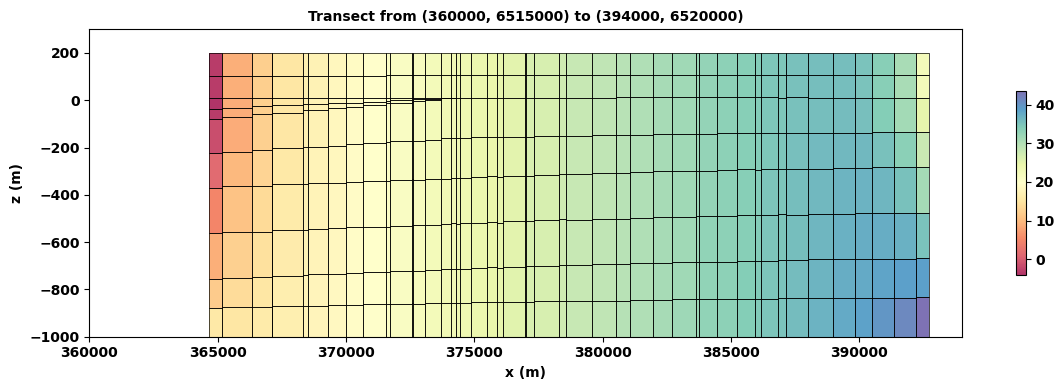

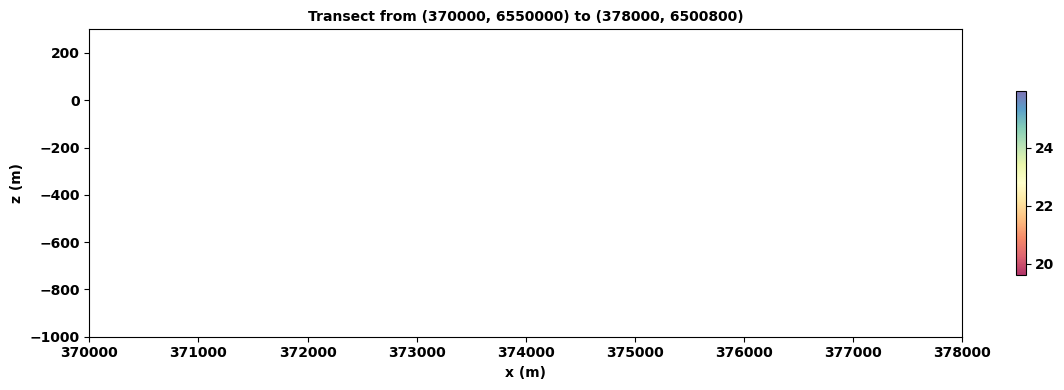

In [64]:
for i in range(len(spatial.xsections)):
    x0, x1 = spatial.xsections[i][0][0], spatial.xsections[i][1][0] # A
    y0, y1 = spatial.xsections[i][0][1], spatial.xsections[i][1][1] # A
    title = f"Transect from ({x0}, {y0}) to ({x1}, {y1})"
    fm.plot_transect(mesh, spatial, geomodel, 'head', title = title, x0 = x0, x1 = x1, y0 = y0, y1 = y1, z1 = 300)